# Mangrove classification in Cedar Key

## Introduction

- Monitoring mangroves facilitate conservation and restoration efforts. 
- Classification models are essential for assessing mangrove distribution and dynamics.
- Here I combined remote sensing and elevation datasets, and built logistic regression model, machine learning models and deep learning model.

## Data preparing

### Data sources
[Sentinel 2A](https://scihub.copernicus.eu/dhus/#/home)
<br>[National Elevation Dataset](https://gdg.sc.egov.usda.gov/Catalog/ProductDescription/NED.html)
<br>[FWC Mangroves](https://geodata.myfwc.com/datasets/mangrove-habitat-in-florida-1/explore?location=27.221800%2C-81.564100%2C7.85)

![Data sources](DataSources.png)

### Data preprocessing

In ArcGIS:
- Convert all datasets into North America 1983 coordiante system
- Resample all datasets into 10 * 10 m resolution
- Calculate NVDI, and composite all raster datasets into one raster file with 7 bands (RGBI_NVDI_NED_Mg.tif)

In Python:

In [2]:
import rasterio
import numpy as np
import os
import math
os.getcwd()

'/blue/zoo4926/yiyangkang/Final_project'

In [7]:
# Convert hyperspectrum raster data into numpy array (X and y)
with rasterio.open('RGBI_NVDI_NED_Mg.tif') as ds:
    arr = ds.read()
    
print(f"Dataset has {arr.shape[0]} bands, with the size of {arr.shape[1]} * {arr.shape[2]} cells in 10 * 10 m resolution")

Dataset has 7 bands, with the size of 1446 * 3671 cells in 10 * 10 m resolution


Band1: Red
<br>Band2: Green
<br>Band3: Blue
<br>Band4: Near-infrared
<br>Band5: Normalized difference vegetation index (NVDI)
<br>Band6: Elevation
<br>Band7: Mangroves labels

In [1]:
# Flatten 3D array to 2D array, and classified mangroves as 1, while no mangroves as 0
arr=np.reshape(arr,(7,arr.shape[1] * arr.shape[2]),order='C')
arr=np.transpose(arr)
arr[:,6][arr[:,6]==65535] = 0
arr[:,6][arr[:,6]!=0] = 1

NameError: name 'np' is not defined

In [9]:
# Because too many no mangroves cell present, leave 40,000 random no mangrove cells and 7,674 mangroves cells
newarr = arr[arr[:,6].argsort()]
newarr = np.delete(newarr,np.where(newarr[:5260000, 6] == 0),axis=0)
newarr[:,6]

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [10]:
y = newarr[:,6].astype(bool) # Mangroves labels, flatten a 2D array into a 1D
X = newarr[:,0:6] # Features including RGB, infrared, NVDI and elevation

# from mlxtend.preprocessing import standardize
# X=standardize(X, columns=[0,1,2,3,4,5]) 
# Normalization would have a infinite norm and mostly 0 datapoints
# Standardization would decrease models accuracy by 0.15, so I choose to apple raw data

In [45]:
# Take a look at input X and y
print('Shape of X :', X.shape,'with nans count:',np.count_nonzero(np.isnan(X)))
print('Shape of y :', y.shape,'with nans count:',np.count_nonzero(np.isnan(y)))
print('Count of True elements (cells with mangroves label) in array: ', np.count_nonzero(y))

Shape of X : (48266, 6) with nans count: 0
Shape of y : (48266,) with nans count: 0
Count of True elements (cells with mangroves label) in array:  7674


## Modeling

### Multivariate logistic regression models

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

Accuracy: 0.836413358746996
Precision: 0.0
Recall: 0.0


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


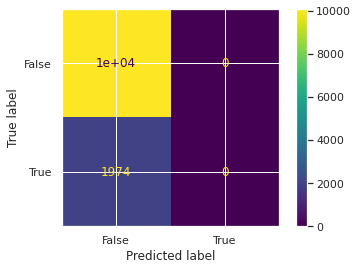

In [151]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_display = ConfusionMatrixDisplay(cnf_matrix,display_labels=logreg.classes_).plot()
print(cnf_display)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


Multivariate logistic regression is a method that classifies binary data, which is suitable for this study. Despite the high accuracy (0.84) it's giving, it is not a good model because not a single mangroves cell was predicted at all (predicted True count = 0). This model does not have implication on classifying mangroves.

### Machine learning models

In [140]:
import seaborn as sns
import pandas as pd

from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn import metrics

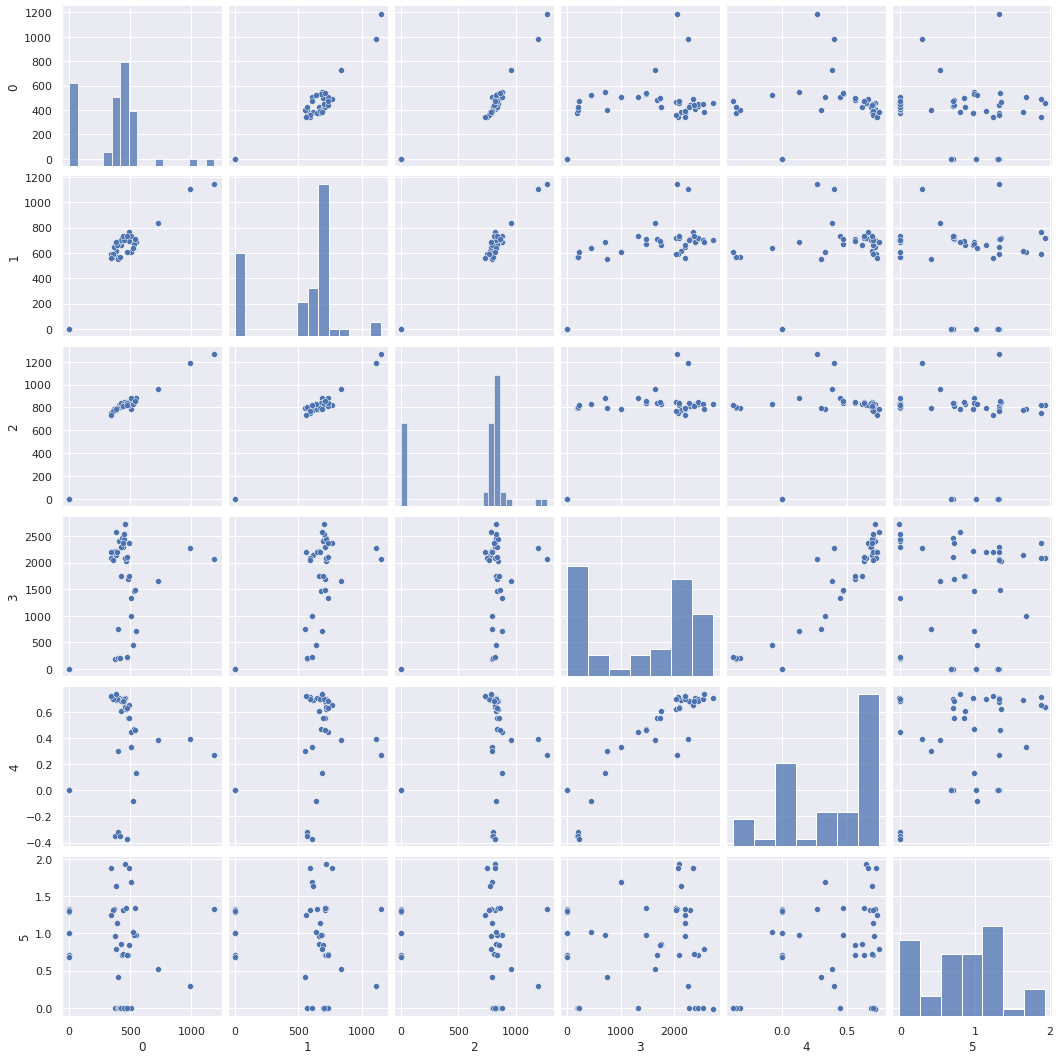

In [106]:
# Explore the data distribution of each feature
sns.set()
df = pd.DataFrame(X)
df1=df.iloc[np.random.choice(np.arange(len(df)), 50, False)]
sns.pairplot(df1)

In [156]:
# Try random forest first, to see the confusion matrix
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)
model= RandomForestClassifier(n_estimators=1000)
model.fit(X_train,y_train)

y_pred=model.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       False       0.99      0.98      0.99     10152
        True       0.91      0.94      0.92      1915

    accuracy                           0.98     12067
   macro avg       0.95      0.96      0.95     12067
weighted avg       0.98      0.98      0.98     12067



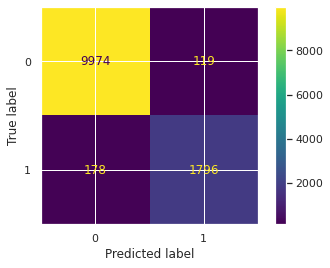

In [157]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

>SVM 0.841 (0.000)
>cart 0.964 (0.002)
>rf 0.975 (0.002)
>bagging 0.972 (0.002)
>AdaBoost 0.951 (0.003)


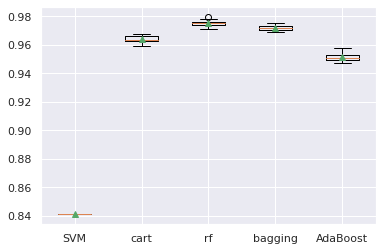

In [123]:
# Try out multiple machine learning models and test accuracy
def get_models():
    models = dict()
    models['SVM'] = SVC(kernel='rbf', C=1)
    models['cart'] = DecisionTreeClassifier()
    models['rf'] = RandomForestClassifier()
    models['bagging'] = BaggingClassifier()
    models['AdaBoost'] = AdaBoostClassifier()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

models= get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Machine learning models showed much higher accuracy than logistic regression model. Among these ML models, random forest produce the best result (highest accuracy), and a high precision value on mangroves and no mangroves cell (0.91 and 0.99). 

### Deep learning models

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [37]:
# Build a neural network model, which has the a ten-neurons layer and a single-neuron layer with sigmoid activiation

# zoom in more mangroves part
# Extra layers 
# satellite existing model to transfer
model = keras.Sequential([
    layers.Dense(10,input_dim=6,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras.optimizers import Adam

lr = 0.001  # Set the learning rate. Start with default for Adam, 0.001
optimizer = Adam(learning_rate=lr)  # Set the optimizer. Start with adam.

model.compile(loss='binary_crossentropy',optimizer=optimizer,  metrics=['accuracy'])

In [32]:
history = model.fit(X,y,epochs=10,validation_split=0.25,batch_size=50,verbose=1)

Epoch 1/10
724/724 [==============================] - 1s 2ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.3641
Epoch 2/10
724/724 [==============================] - 1s 2ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.3641
Epoch 3/10
724/724 [==============================] - 1s 2ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.3641
Epoch 4/10
724/724 [==============================] - 1s 2ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.3641
Epoch 5/10
724/724 [==============================] - 1s 2ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.3641
Epoch 6/10
724/724 [==============================] - 1s 2ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.3641
Epoch 7/10
724/724 [==============================] - 1s 2ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.3641
Epoch 8/10
724/724 [============================

Loss is nan. https://stackoverflow.com/questions/33962226/common-causes-of-nans-during-training-of-neural-networks

## Discussion

Some drawbacks on this study and potential improvements include:
- The mangrove label data is not accurate. A lot of mangrove patches were not labeled in this dataset provided by Florida FWC. Mangroves labeling is essential to the model building, and requires more accurate dataset to improve current models.

- Data size limit the model's predicting capability. This study focus on mangroves in Cedar Key, which is a relatively small region due to the limitation in time and computing power. To make high-accuracy prediction on a larger scale, the range of samples need to increase (Florida, Gulf of Mexico, etc.) without sacrificing resolution and data layers (features).